# ML methods, week 12 demo

## Libraries and settings

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

## Housing data

In [3]:
# Corrected Boston Housing data by Bivand, Nowosad and Lovelace
# https://jakubnowosad.com/spData/reference/boston.html
dfo = pd.read_csv("boston_corrected.tsv", sep='\t', skiprows=9)

In [80]:
dfo.columns

Index(['OBS.', 'TOWN', 'TOWN#', 'TRACT', 'LON', 'LAT', 'MEDV', 'CMEDV', 'CRIM',
       'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [8]:
# first 7 columns are not needed, being
# geographical, obs(id), and uncorrected housing value
df = dfo.drop(['OBS.', 'LON', 'LAT', 'TRACT', 'TOWN', 'TOWN#', 'MEDV'], axis=1, inplace=False)

In [4]:
dfo.head(2)
# target variable is CMEDV median value of housing in area

OBS.        TOWN  TOWN#  TRACT     LON      LAT  MEDV  CMEDV     CRIM  \
0     1      Nahant      0   2011 -70.955  42.2550  24.0   24.0  0.00632   
1     2  Swampscott      1   2021 -70.950  42.2875  21.6   21.6  0.02731   

     ZN  ...  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO      B  \
0  18.0  ...     0  0.538  6.575  65.2  4.0900    1  296     15.3  396.9   
1   0.0  ...     0  0.469  6.421  78.9  4.9671    2  242     17.8  396.9   

   LSTAT  
0   4.98  
1   9.14  

[2 rows x 21 columns]

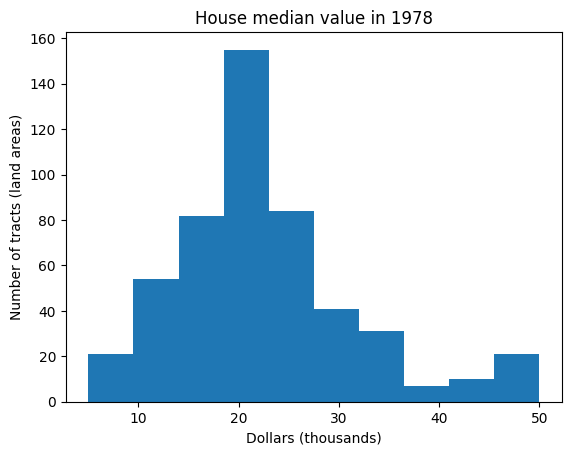

In [71]:
plt.hist(dfo.CMEDV)
plt.title('House median value in 1978')
plt.xlabel('Dollars (thousands)')
plt.ylabel('Number of tracts (land areas)')
plt.show()

In [6]:
from scipy.stats.mstats import normaltest
normaltest(dfo.CMEDV.values)
# is not a Normal distribution

NormaltestResult(statistic=91.57490454794716, pvalue=1.3024532297084256e-20)

In [81]:
df.dtypes.value_counts()

float64    11
int64       3
Name: count, dtype: int64

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CMEDV    506 non-null    float64
 1   CRIM     506 non-null    float64
 2   ZN       506 non-null    float64
 3   INDUS    506 non-null    float64
 4   CHAS     506 non-null    int64  
 5   NOX      506 non-null    float64
 6   RM       506 non-null    float64
 7   AGE      506 non-null    float64
 8   DIS      506 non-null    float64
 9   RAD      506 non-null    int64  
 10  TAX      506 non-null    int64  
 11  PTRATIO  506 non-null    float64
 12  B        506 non-null    float64
 13  LSTAT    506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [9]:
df.corr()
# find which features correlate with target more (+ or -)

CMEDV      CRIM        ZN     INDUS      CHAS       NOX        RM  \
CMEDV    1.000000 -0.389582  0.360386 -0.484754  0.175663 -0.429300  0.696304   
CRIM    -0.389582  1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247   
ZN       0.360386 -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991   
INDUS   -0.484754  0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676   
CHAS     0.175663 -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251   
NOX     -0.429300  0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188   
RM       0.696304 -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000   
AGE     -0.377999  0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265   
DIS      0.249315 -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246   
RAD     -0.384766  0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847   
TAX     -0.471979  0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048   
PTRATIO -0.505655  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501   
B        0.334861 -0.385064  0.175520 -0.356977  0.048788 -0.380051  0.128069   
LSTAT   -0.740836  0.455621 -0.412995  0.603800 -0.053929  0.590879 -0.613808   

              AGE       DIS       RAD       TAX   PTRATIO         B     LSTAT  
CMEDV   -0.377999  0.249315 -0.384766 -0.471979 -0.505655  0.334861 -0.740836  
CRIM     0.352734 -0.379670  0.625505  0.582764  0.289946 -0.385064  0.455621  
ZN      -0.569537  0.664408 -0.311948 -0.314563 -0.391679  0.175520 -0.412995  
INDUS    0.644779 -0.708027  0.595129  0.720760  0.383248 -0.356977  0.603800  
CHAS     0.086518 -0.099176 -0.007368 -0.035587 -0.121515  0.048788 -0.053929  
NOX      0.731470 -0.769230  0.611441  0.668023  0.188933 -0.380051  0.590879  
RM      -0.240265  0.205246 -0.209847 -0.292048 -0.355501  0.128069 -0.613808  
AGE      1.000000 -0.747881  0.456022  0.506456  0.261515 -0.273534  0.602339  
DIS     -0.747881  1.000000 -0.494588 -0.534432 -0.232471  0.291512 -0.496996  
RAD      0.456022 -0.494588  1.000000  0.910228  0.464741 -0.444413  0.488676  
TAX      0.506456 -0.534432  0.910228  1.000000  0.460853 -0.441808  0.543993  
PTRATIO  0.261515 -0.232471  0.464741  0.460853  1.000000 -0.177383  0.374044  
B       -0.273534  0.291512 -0.444413 -0.441808 -0.177383  1.000000 -0.366087  
LSTAT    0.602339 -0.496996  0.488676  0.543993  0.374044 -0.366087  1.000000

<Axes: >

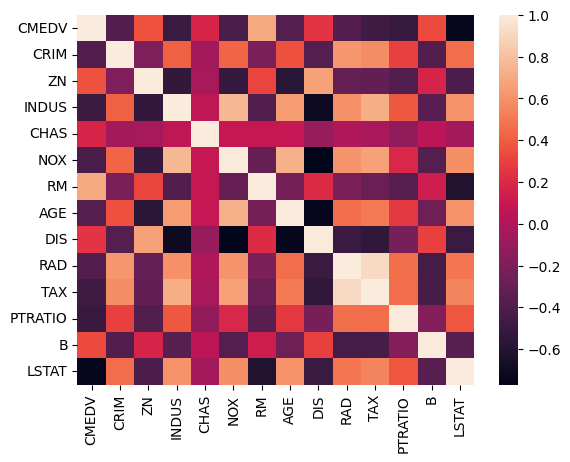

In [10]:
sns.heatmap(df.corr(), annot=False)
plt.show()

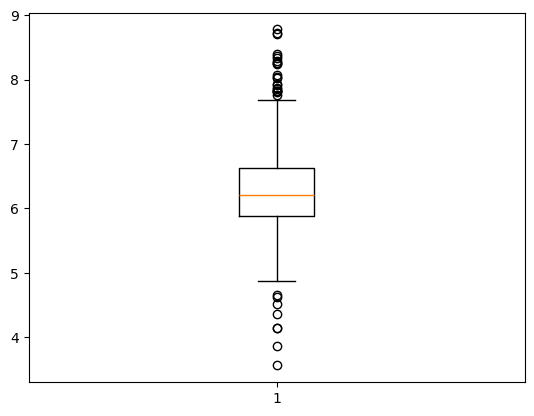

In [73]:
# view distribution of 6 most correlated features
plt.boxplot(df.RM)
plt.show()

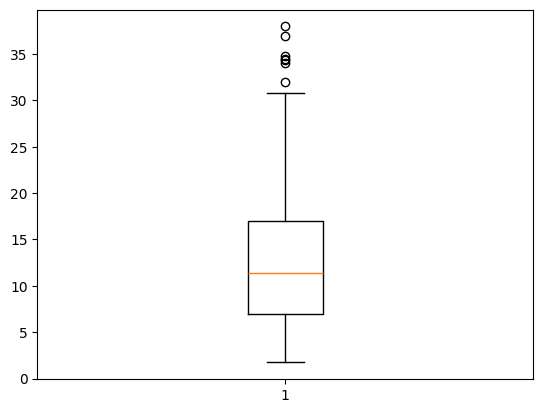

In [74]:
plt.boxplot(df.LSTAT)
plt.show()

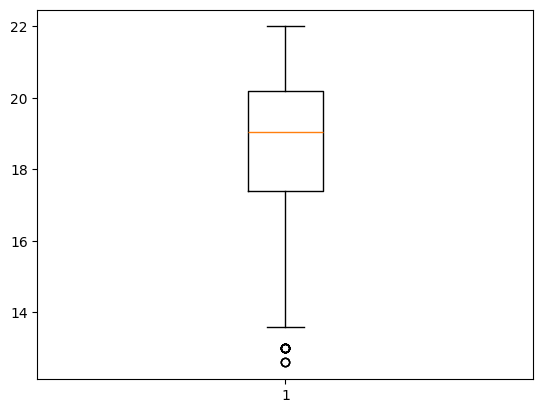

In [75]:
plt.boxplot(df.PTRATIO)
plt.show()

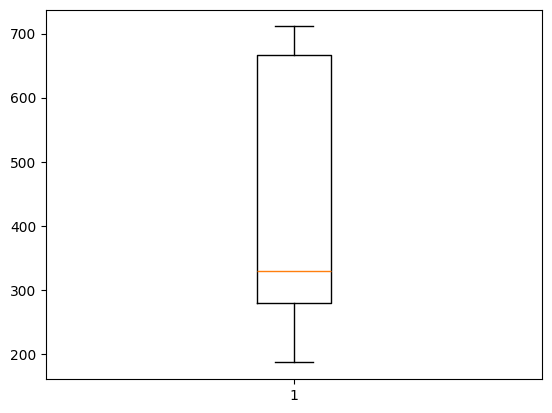

In [76]:
plt.boxplot(df.TAX)
plt.show()

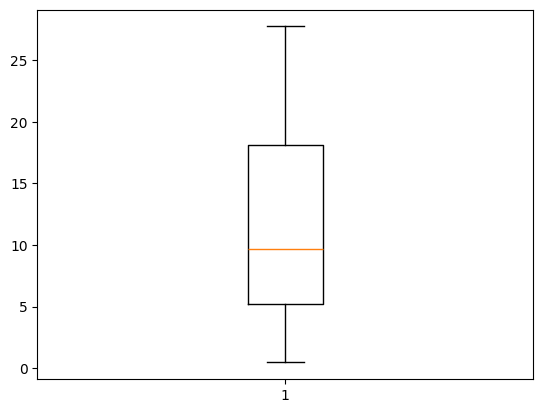

In [77]:
plt.boxplot(df.INDUS)
plt.show()

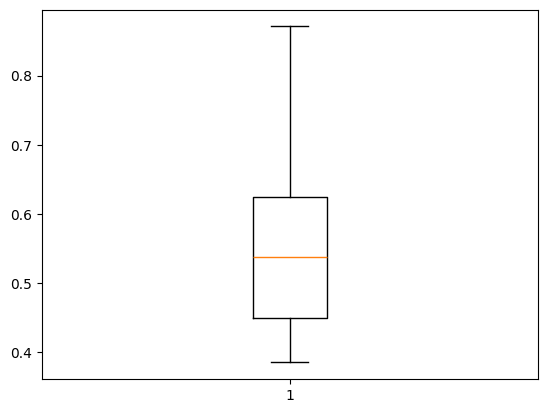

In [78]:
plt.boxplot(df.NOX)
plt.show()

## Prepare train & test data

In [11]:
# CMEDV = corrected median house value
y = df.CMEDV
print(y.shape)
print(y[:3])

(506,)
0    24.0
1    21.6
2    34.7
Name: CMEDV, dtype: float64


In [47]:
# CRIM = crime rate; LSTAT = working class; NOX = air quality; PTRATIO = pupil:teacher ratio; DIS = distance to employment centres; RAD = radial road proximity; RM = rooms
X = df[['ZN', 'TAX', 'CRIM', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM']]
X = df.drop('CMEDV')
print(X.shape)
print(X[:3])

(506, 9)
     ZN  TAX     CRIM     DIS  LSTAT    NOX  PTRATIO  RAD     RM
0  18.0  296  0.00632  4.0900   4.98  0.538     15.3    1  6.575
1   0.0  242  0.02731  4.9671   9.14  0.469     17.8    2  6.421
2   0.0  242  0.02729  4.9671   4.03  0.469     17.8    2  7.185


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("X_test shape: {}, y_test shape {}".format(X_test.shape, y_test.shape))

X_train shape: (404, 9), y_train shape: (404,)
X_test shape: (102, 9), y_test shape (102,)


## Linear Regression, only 1 feature

In [86]:
# one feature only (lower "working class" % in population)
# x1 = np.array(df.LSTAT).reshape(-1,1)
x1 = pd.DataFrame(df['LSTAT'])
print(x1.shape)
print(type(x1))

(506, 1)
<class 'pandas.core.frame.DataFrame'>


In [87]:
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=42)
print("x1_train shape: {}, x1_test shape: {}, y_train shape: {}, y_test shape {}".format(x1_train.shape, x1_test.shape, y_train.shape, y_test.shape))

x1_train shape: (404, 1), x1_test shape: (102, 1), y_train shape: (404,), y_test shape (102,)


In [88]:
model = LinearRegression()
model.fit(x1_train, y_train)

LinearRegression()

In [89]:
print(model.coef_)
print(model.intercept_)

[-0.9689]
34.87134431878069


In [90]:
y_pred = model.predict(x1_test).reshape(-1,1)
print(y_pred.shape)
y_pred[:3]

(102, 1)


array([[26.1127],
       [31.4512],
       [17.3638]])

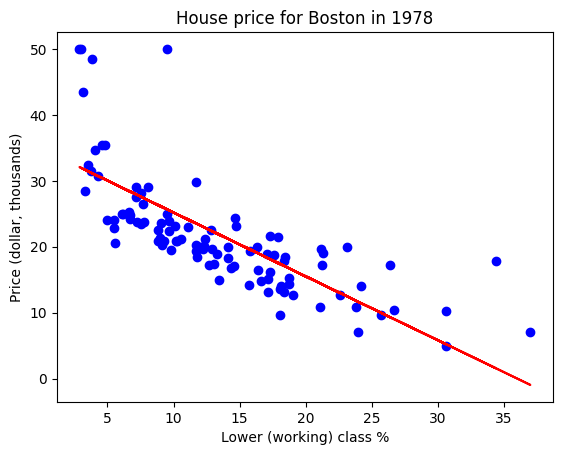

In [91]:
plt.scatter(x1_test, y_test, color='blue')
plt.plot(x1_test, y_pred, color='red')
plt.title("House price for Boston areas in 1978")
plt.xlabel("Lower (working) class %")
plt.ylabel("Price (dollar, thousands)")
plt.show()

In [ ]:
# AUROC metric unsuitable for Linear Regression

In [94]:
# R-squared
r2_score(y_test, model.predict(x1_test))

0.5427642306533597

## Linear Regression, another single feature

In [95]:
# one feature only (mean number of rooms per house)
x1 = pd.DataFrame(df['RM'])
print(x1.shape)
print(type(x1))

(506, 1)
<class 'pandas.core.frame.DataFrame'>


In [96]:
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=42)
print("x1_train shape: {}, x1_test shape: {}, y_train shape: {}, y_test shape {}".format(x1_train.shape, x1_test.shape, y_train.shape, y_test.shape))

x1_train shape: (404, 1), x1_test shape: (102, 1), y_train shape: (404,), y_test shape (102,)


In [97]:
model = LinearRegression()
model.fit(x1_train, y_train)

LinearRegression()

In [98]:
print(model.coef_)
print(model.intercept_)

[9.3449]
-36.21968671198455


In [99]:
y_pred = model.predict(x1_test).reshape(-1,1)

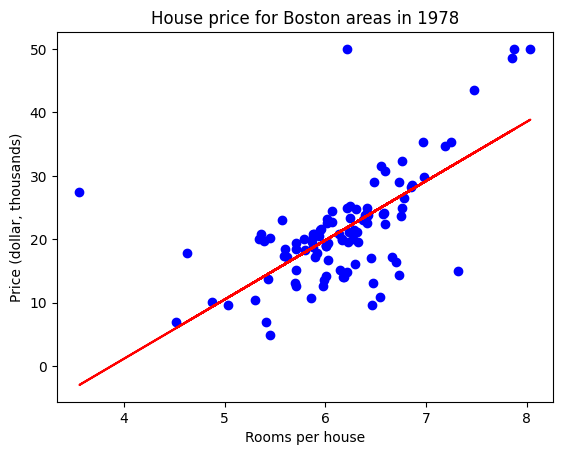

In [100]:
plt.scatter(x1_test, y_test, color='blue')
plt.plot(x1_test, y_pred, color='red')
plt.title("House price for Boston areas in 1978")
plt.xlabel("Rooms per house")
plt.ylabel("Price (dollar, thousands)")
plt.show()

In [ ]:
# AUROC metric unsuitable for Linear Regression

In [101]:
# R-squared
r2_score(y_test, model.predict(x1_test))

0.36766927564418794

## Polynomial regression

In [43]:
x1.sort_values(by=['RM'], inplace=True, ascending=True)

In [44]:
poly = PolynomialFeatures(degree=2)
poly_features = poly.fit_transform(x1)
poly_model = LinearRegression()
poly_model.fit(poly_features, y)

LinearRegression()

In [45]:
y_pred = poly_model.predict(poly_features)
y_pred[:5]

array([24.0960, 24.5377, 24.8156, 24.8156, 24.9571])

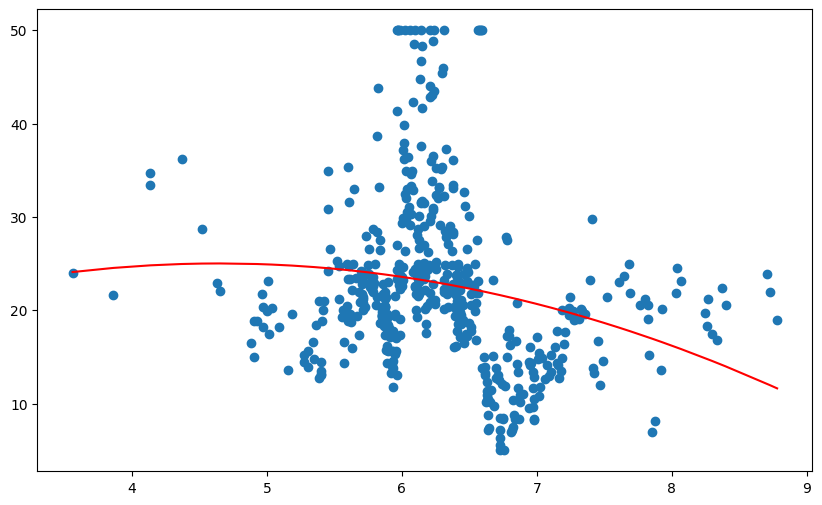

In [46]:
plt.figure(figsize=(10,6))
plt.scatter(x1, y)
plt.plot(x1, y_pred, c='red')
plt.show()

In [ ]:
r2_score(y, poly_model.predict(x1)) # error

## Multiple variables for Linear Regression

In [49]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [50]:
y_pred = model.predict(X_test).reshape(-1,1)
y_pred.shape

(102, 1)

In [51]:
print(model.coef_)
print(model.intercept_)

[0.0474 -0.0136 -0.1264 -1.5799 -0.5593 -17.2764 -0.9347 0.2971 3.6905]
41.85951887619595


In [52]:
# R squared
r2 = r2_score(y_test, model.predict(X_test))
print(r2)

0.710787123424206


In [53]:
# adjust R-squared
print(f"{X.shape[1]} features")
1 - (1-r2) * (len(y)-1) / (len(y)-X.shape[1] -1)

9 features


0.7055393091315001

In [54]:
# Accuracy?
print(model.score(X, y))

0.732129058069559


## Decision Tree Regressor

In [ ]:
# refresh housing data
# df = dfo.drop(['OBS.', 'LON', 'LAT', 'TRACT', 'TOWN', 'TOWN#', 'MEDV'], axis=1, inplace=False)
# y = df.CMEDV
# X = df.drop('CMEDV', axis=1, inplace=False)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [55]:
model = DecisionTreeRegressor(random_state=42)

In [56]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred[:7]

array([28.1000, 30.5000, 15.2000, 18.9000, 14.3000, 18.5000, 21.7000])

In [57]:
X.columns

Index(['ZN', 'TAX', 'CRIM', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM'], dtype='object')

In [58]:
mean_squared_error(y_test, y_pred)

12.245784313725489

[Text(0.6929868002073459, 0.9705882352941176, 'x[8] <= 6.838\nsquared_error = 86.402\nsamples = 404\nvalue = 22.802'),
 Text(0.4497695127369668, 0.9117647058823529, 'x[4] <= 14.4\nsquared_error = 39.053\nsamples = 328\nvalue = 19.73'),
 Text(0.23610596860189573, 0.8529411764705882, 'x[3] <= 1.385\nsquared_error = 24.818\nsamples = 195\nvalue = 23.166'),
 Text(0.16561759478672985, 0.7941176470588235, 'x[4] <= 10.505\nsquared_error = 91.577\nsamples = 4\nvalue = 44.475'),
 Text(0.16324792654028436, 0.7352941176470589, 'squared_error = 0.0\nsamples = 3\nvalue = 50.0'),
 Text(0.16798726303317535, 0.7352941176470589, 'squared_error = -0.0\nsamples = 1\nvalue = 27.9'),
 Text(0.3065943424170616, 0.7941176470588235, 'x[8] <= 6.543\nsquared_error = 13.711\nsamples = 191\nvalue = 22.72'),
 Text(0.17272659952606634, 0.7352941176470589, 'x[8] <= 6.099\nsquared_error = 8.053\nsamples = 156\nvalue = 21.674'),
 Text(0.08354931872037914, 0.6764705882352942, 'x[8] <= 5.76\nsquared_error = 5.562\nsample

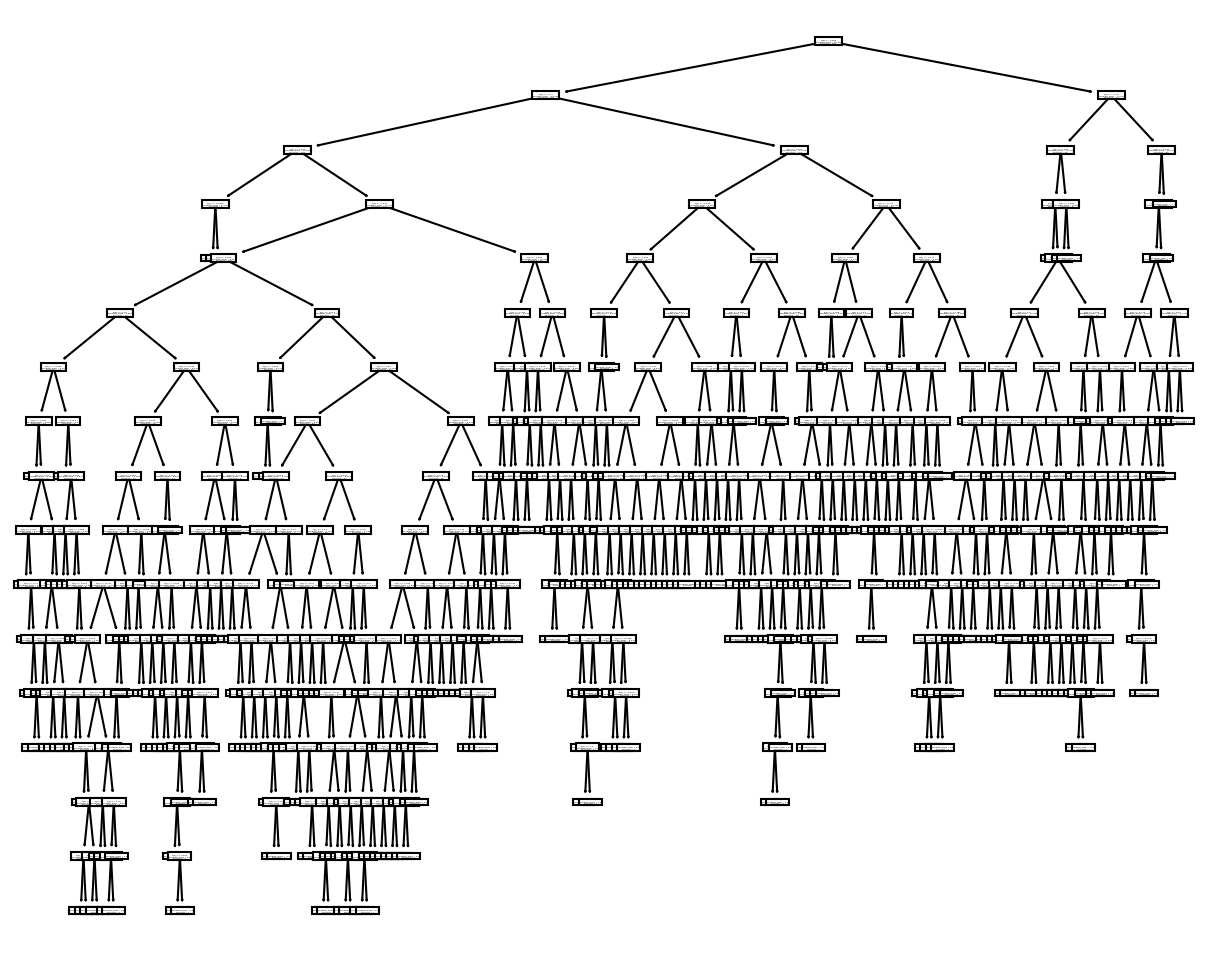

In [59]:
from sklearn import tree
plt.figure(figsize=(10,8), dpi=150)
tree.plot_tree(model)

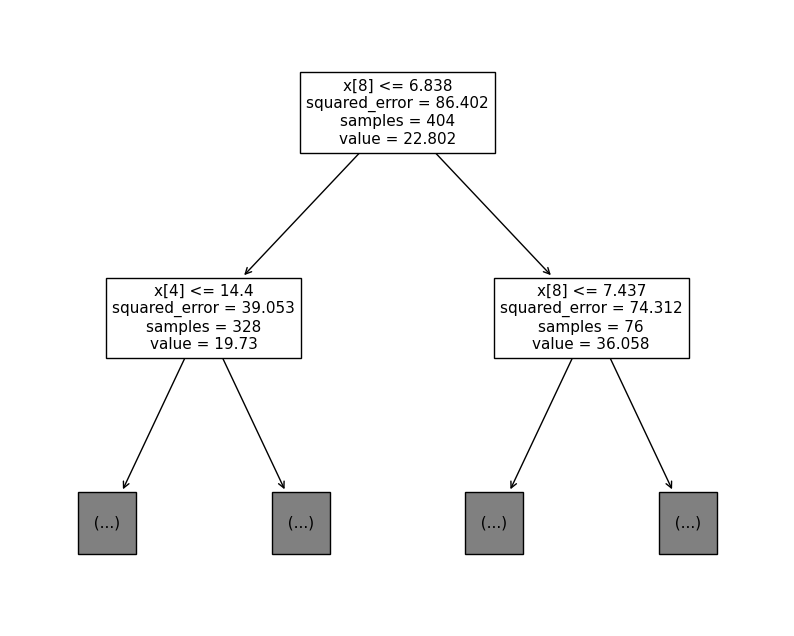

In [60]:
plt.figure(figsize=(10,8))
tree.plot_tree(model, max_depth=1)
plt.show()

## RandomForestRegressor

In [61]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=2, random_state=42)

In [62]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=200, random_state=42)

In [63]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

21.69353473270322

In [64]:
print(model.feature_names_in_)
model.feature_importances_
# RM and LSTAT are most important

['ZN' 'TAX' 'CRIM' 'DIS' 'LSTAT' 'NOX' 'PTRATIO' 'RAD' 'RM']


array([0.0004, 0.0000, 0.0031, 0.0013, 0.3936, 0.0019, 0.0000, 0.0000,
       0.5996])